# Reinforcement Learning Project: Simulating the Board Game "Ghosts" by Alex Randolph

Creating a reinforcement learning project to simulate the board game *Ghosts* involves several steps. This guide will cover the game’s rules and logic, and outline a step-by-step approach to implementing a reinforcement learning agent using Gym and Q-Learning.

## Game Rules and Logic

### Game Setup
- **Board:** The game is played on a 6x6 board.
- **Players:** Each player has 8 ghosts: 4 good ghosts and 4 evil ghosts. The identity of each ghost is hidden from the opponent.
- **Placement:** Players arrange their ghosts in the back two rows on their side of the board.

### Game Objective
A player wins by:
1. Capturing all four of the opponent's good ghosts.
2. Having the opponent capture all four of their evil ghosts.
3. Moving one of their good ghosts to one of the opponent's corner exits.

### Game Play
- **Turns:** Players take turns moving one ghost per turn.
- **Movement:** Ghosts can move one square in any direction (up, down, left, right) but not diagonally.
- **Capturing:** A ghost can capture an opponent's ghost by moving into its square, revealing the captured ghost's identity.


In [1]:
import gym
from gym import spaces
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import ListedColormap
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pickle  # or import joblib if you prefer


In [3]:
# Actions
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
PLACE_BLUE = 4
PLACE_RED = 5
CAPTURE_UP = 6
CAPTURE_RIGHT = 7
CAPTURE_DOWN = 8
CAPTURE_LEFT = 9

ACTIONS = [UP, RIGHT, DOWN, LEFT, PLACE_BLUE, PLACE_RED, CAPTURE_UP, CAPTURE_RIGHT, CAPTURE_DOWN, CAPTURE_LEFT]

# Update ACTION_NAMES
ACTION_NAMES = {
    UP: "Move Up",
    RIGHT: "Move Right",
    DOWN: "Move Down",
    LEFT: "Move Left",
    PLACE_BLUE: "Place Blue Piece",
    PLACE_RED: "Place Red Piece",
    CAPTURE_UP: "Capture Up",
    CAPTURE_RIGHT: "Capture Right",
    CAPTURE_DOWN: "Capture Down",
    CAPTURE_LEFT: "Capture Left"
}

# Define possible spaces
EMPTY = 0
PLAYER_BLUE = 1
PLAYER_RED = 2
OPPONENT_BLUE = 3
OPPONENT_RED = 4
PLAYER_MASKED = 5
OPPONENT_MASKED = 6


# Define mappings from space values to names
SPACE_NAMES = {
    EMPTY: "Empty",
    PLAYER_BLUE: "Player Blue",
    PLAYER_RED: "Player Red",
    OPPONENT_BLUE: "Opponent Blue",
    OPPONENT_RED: "Opponent Red",
    PLAYER_MASKED: "Player Masked",
    OPPONENT_MASKED: "Opponent Masked"
}

In [49]:
import gym
import numpy as np
from gym import spaces


class GhostsEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(GhostsEnv, self).__init__()

        # Size of the board is size x size
        self.size = 6

        # Action space is tuple: (action, x, y, player)
        # action: 0-3 (move up, right, down, left), 5 (place blue), 6 (place red), 7-10 (capture up, right, down, left)
        self.action_space = spaces.Tuple((spaces.Discrete(11), spaces.Discrete(self.size), spaces.Discrete(self.size), spaces.Discrete(2)))

        # Reward
        self.reward = 0

        # Initialize the game state
        self.reset(0)

        self.move_counter = 0
        self.max_moves = 100

    def reset(self,player=0):
        # Initialize the board
        self.board = np.zeros((self.size, self.size), dtype=int)

        # Reset phase (0: placement, 1: movement)
        self.phase = 0

        # Reset ghost counts
        self.player_blue_count = 0
        self.opponent_blue_count = 0
        self.player_red_count = 0
        self.opponent_red_count = 0
        self.move_counter = 0
        return self.board

    
    def get_masked_state(self, player):
        masked_state = np.copy(self.board)
        if player == 0:
            # Mask opponent pieces for player 0
            masked_state[masked_state == OPPONENT_BLUE] = OPPONENT_MASKED
            masked_state[masked_state == OPPONENT_RED] = OPPONENT_MASKED
        else:
            # Mask player pieces for player 1
            masked_state[masked_state == PLAYER_BLUE] = PLAYER_MASKED
            masked_state[masked_state == PLAYER_RED] = PLAYER_MASKED
        return masked_state
    
    def legal_placement_actions(self, player, board=None, flipped=False):
        if board is None:
            board = self.board

        if player == 0:
            rows = [4, 5]
        else:
            rows = [0, 1]
            
        # Recalculate counts
        player_blue_count = np.count_nonzero(board == PLAYER_BLUE)
        player_red_count = np.count_nonzero(board == PLAYER_RED)
        opponent_blue_count = np.count_nonzero(board == OPPONENT_BLUE)
        opponent_red_count = np.count_nonzero(board == OPPONENT_RED)

        actions = []
        valid_cells = [(y, x) for y in rows for x in range(1, self.size - 1) if board[y, x] == EMPTY]

        if player == 0:
            if player_blue_count < 4:
                for x, y in valid_cells:
                    if flipped:
                        actions.append((4, x, y, 1))
                    else:
                        actions.append((4, x, y, player))
            if player_red_count < 4:
                for x, y in valid_cells:
                    if flipped:
                        actions.append((5, x, y, 1))
                    else:
                        actions.append((5, x, y, player))
        else:
            if opponent_blue_count < 4:
                for x, y in valid_cells:
                    actions.append((4, x, y, player))
            if opponent_red_count < 4:
                for x, y in valid_cells:
                    actions.append((5, x, y, player))

        return actions



    def legal_movement_actions(self, player, board=None):
        if board is None:
            board = self.board
        actions = []
        for y in range(self.size):
            for x in range(self.size):
                piece = board[x, y]
                if (player == 0 and piece in [PLAYER_BLUE, PLAYER_RED]) or (player == 1 and piece in [OPPONENT_BLUE, OPPONENT_RED]):
                    # Check all four directions for movement and capture
                    if y > 0:
                        if self.board[x, y-1] == EMPTY:
                            actions.append((LEFT, x, y, player))
                        elif player == 0 and self.board[x, y-1] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_LEFT, x, y, player))
                        elif player == 1 and self.board[x, y-1] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_LEFT, x, y, player))
                    
                    if y < self.size - 1:
                        if self.board[x, y+1] == EMPTY:
                            actions.append((RIGHT, x, y, player))
                        elif player == 0 and self.board[x, y+1] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_RIGHT, x, y, player))
                        elif player == 1 and self.board[x, y+1] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_RIGHT, x, y, player))
                    
                    if x < self.size - 1:
                        if self.board[x+1, y] == EMPTY:
                            if player == 0:
                                actions.append((DOWN, x, y, player))
                            else:
                                actions.append((DOWN, x, y, player))
                        elif player == 0 and self.board[x+1, y] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_DOWN, x, y, player))
                        elif player == 1 and self.board[x+1, y] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_DOWN, x, y, player))
                    
                    if x > 0:
                        if self.board[x-1, y] == EMPTY:
                            if player == 0:
                                actions.append((UP, x, y, player))
                            else:
                                actions.append((UP, x, y, player))
                        elif player == 0 and self.board[x-1, y] in [OPPONENT_BLUE, OPPONENT_RED]:
                            actions.append((CAPTURE_UP, x, y, player))
                        elif player == 1 and self.board[x-1, y] in [PLAYER_BLUE, PLAYER_RED]:
                            actions.append((CAPTURE_UP, x, y, player))
        
        return actions

    def step(self, action):
        self.reward = 0
        if self.phase == 0:
            self._place(action)
        else:
            self._take_action(action)
            self.move_counter += 1  # Increment move counter only in movement phase

        player = action[3]
        done = self._is_done(player)
        reward = self._get_reward()

        # Check if move limit is reached
        if self.move_counter >= self.max_moves:
            done = 3  # Use 3 to indicate a draw due to move limit
            reward = -50  # Negative reward for both players


        return self.board, reward, done, {}


    def _place(self, action):
        action, x, y, player = action
        if player == 0:
            if action == 4:
                self.board[x, y] = PLAYER_BLUE
                self.player_blue_count += 1
            elif action == 5:
                self.board[x, y] = PLAYER_RED
                self.player_red_count += 1
        else:
            if action == 4:
                self.board[x, y] = OPPONENT_BLUE
                self.opponent_blue_count += 1
            elif action == 5:
                self.board[x, y] = OPPONENT_RED
                self.opponent_red_count += 1

    def _take_action(self, action):
        action, x, y, player = action
        if action in [UP, DOWN, LEFT, RIGHT]:
            self._move(x, y, action, player)
        elif action in [CAPTURE_UP, CAPTURE_DOWN, CAPTURE_LEFT, CAPTURE_RIGHT]:
            self._capture(x, y, action, player)

    def _move(self, x, y, direction, player):
        new_x, new_y = x, y
        if direction == UP:
            new_x = x - 1
        elif direction == DOWN:
            new_x = x + 1
        elif direction == LEFT:
            new_y = y - 1
        elif direction == RIGHT:
            new_y = y + 1

        if 0 <= new_x < self.size and 0 <= new_y < self.size and self.board[new_x, new_y] == EMPTY:
            self.board[new_x, new_y] = self.board[x, y]
            self.board[x, y] = EMPTY

    def _capture(self, x, y, direction, player):
        new_x, new_y = x, y
        if direction == CAPTURE_UP:
            new_x = x - 1
        elif direction == CAPTURE_DOWN:
            new_x = x + 1
        elif direction == CAPTURE_LEFT:
            new_y = y - 1
        elif direction == CAPTURE_RIGHT:
            new_y = y + 1

        if 0 <= new_x < self.size and 0 <= new_y < self.size:
            captured_piece = self.board[new_x, new_y]
            if (player == 0 and captured_piece in [OPPONENT_BLUE, OPPONENT_RED]) or \
               (player == 1 and captured_piece in [PLAYER_BLUE, PLAYER_RED]):
                self.board[new_x, new_y] = self.board[x, y]
                self.board[x, y] = EMPTY
                if captured_piece == OPPONENT_BLUE:
                    self.opponent_blue_count -= 1
                    self.reward = 20 if player == 0 else -20
                elif captured_piece == OPPONENT_RED:
                    self.opponent_red_count -= 1
                    self.reward = -20 if player == 0 else 20
                elif captured_piece == PLAYER_BLUE:
                    self.player_blue_count -= 1
                    self.reward = -20 if player == 0 else 20
                elif captured_piece == PLAYER_RED:
                    self.player_red_count -= 1
                    self.reward = 20 if player == 0 else -20

    def _get_reward(self):
        
        if self.phase == 0:
            return 0  # No reward during placement phase
        
        if self.move_counter >= self.max_moves:
            return -50  # Negative reward for both players in case of a draw

        
        # Small negative reward for each move to encourage efficiency
        return self.reward - 2
    
    def _is_done(self, player):

        if self.phase == 0:
            if self.player_blue_count == 4 and self.player_red_count == 4 and self.opponent_blue_count == 4 and self.opponent_red_count == 4:
                self.phase = 1
                return 2
            return 2
        else:
            if self.player_blue_count == 0 or self.opponent_red_count == 0:
                # Debug:
                if self.player_blue_count == 0:
                    print("Player Blue count is 0")
                if self.opponent_red_count == 0:
                    print("Opponent Red count is 0")
                if player == 0:
                    self.reward -= 500
                    return 1
                else:
                    self.reward += 500
                    return 1
            elif self.player_red_count == 0 or self.opponent_blue_count == 0:
                # Debug:
                if self.player_red_count == 0:
                    print("Player Red count is 0")
                if self.opponent_blue_count == 0:
                    print("Opponent Blue count is 0")
                if player == 0:
                    self.reward += 500
                    return 0
                else:
                    self.reward -= -500
                    return 0
            
            # Check if there are blue player pieces on the opponent's angles
            if self.board[0, 0] == PLAYER_BLUE or self.board[0, self.size - 1] == PLAYER_BLUE:
                # Debug:
                if self.board[0, 0] == PLAYER_BLUE:
                    print("Player Blue at 0, 0")
                if self.board[0, self.size - 1] == PLAYER_BLUE:
                    print("Player Blue at 0, size - 1")

                if player == 0:
                    self.reward += 500
                    return 0
                else:
                    self.reward -= 500
                    return 0
            if self.board[self.size - 1, 0] == OPPONENT_BLUE or self.board[self.size - 1, self.size - 1] == OPPONENT_BLUE:
                if player == 0:
                    self.reward -= 500
                    return 1
                else:
                    self.reward += 500
                    return 1

            if self.move_counter >= self.max_moves:
                self.reward = -50  # Negative reward for both players
                return 3  # Use 3 to indicate a draw due to move limit
        
            return 2
            
                

    def render(self, mode='human'):
        print("\n " + " ".join([str(i) for i in range(self.size)]))
        for y in range(self.size):
            row = [str(y)]
            for x in range(self.size):
                if self.board[y, x] == EMPTY:
                    row.append(".")
                elif self.board[y, x] == PLAYER_BLUE:
                    row.append("B")
                elif self.board[y, x] == PLAYER_RED:
                    row.append("R")
                elif self.board[y, x] == OPPONENT_BLUE:
                    row.append("M")
                elif self.board[y, x] == OPPONENT_RED:
                    row.append("M")
            print(" ".join(row))
        print()
    
    def close(self):
        pass


Episode 400: Training in progress...


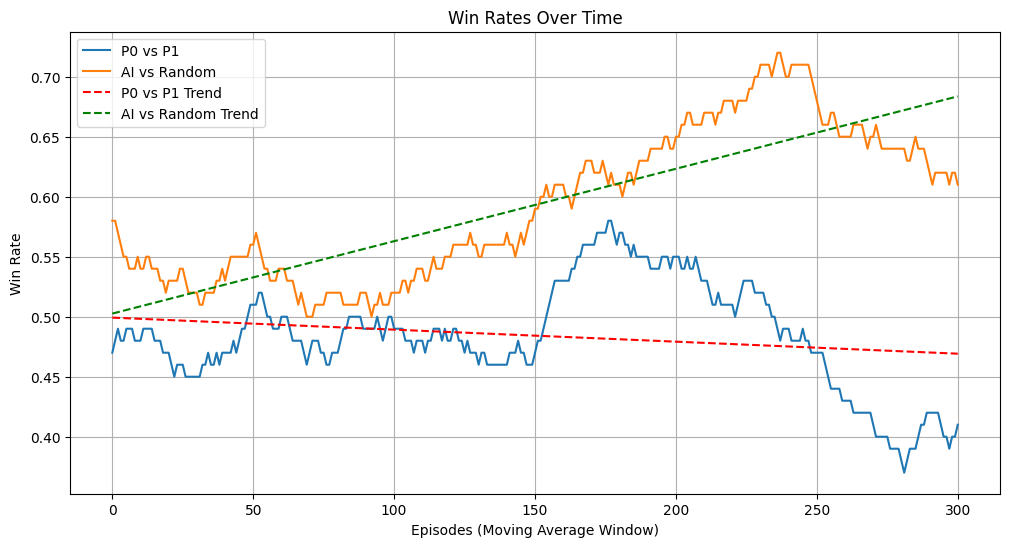

Recent win rate against random: 0.59
Episode 800: Training in progress...


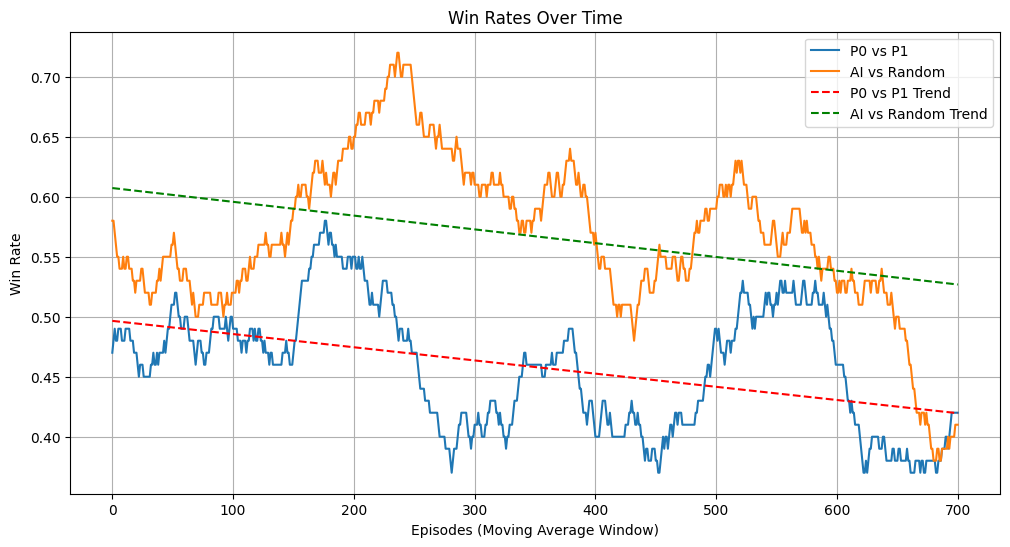

Recent win rate against random: 0.52
Episode 1200: Training in progress...


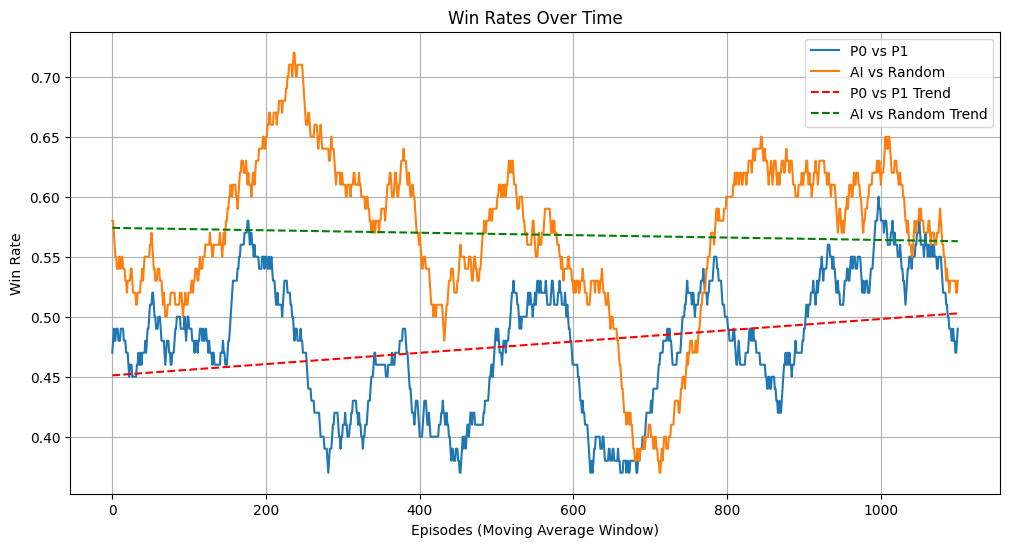

Recent win rate against random: 0.59
Episode 1600: Training in progress...


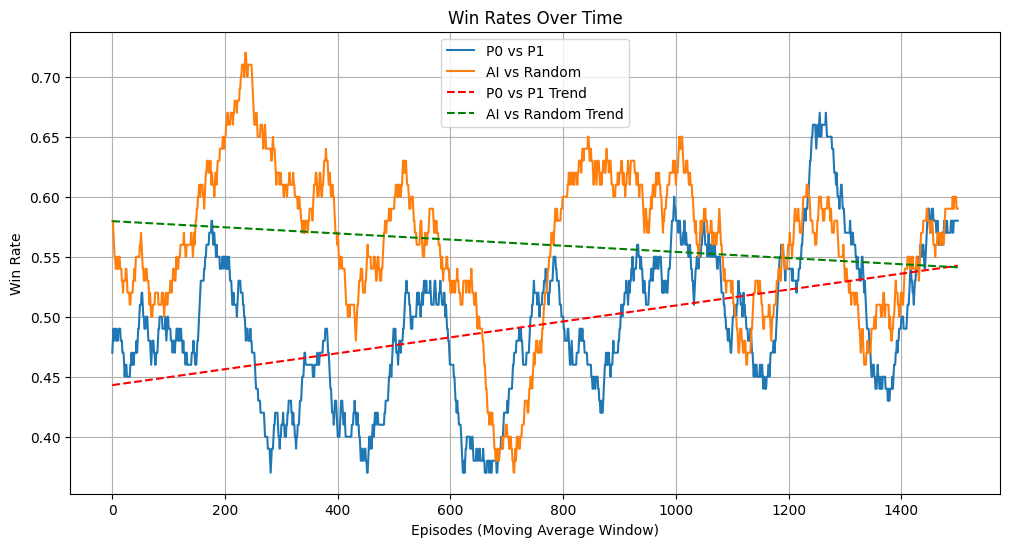

Recent win rate against random: 0.55
Episode 2000: Training in progress...


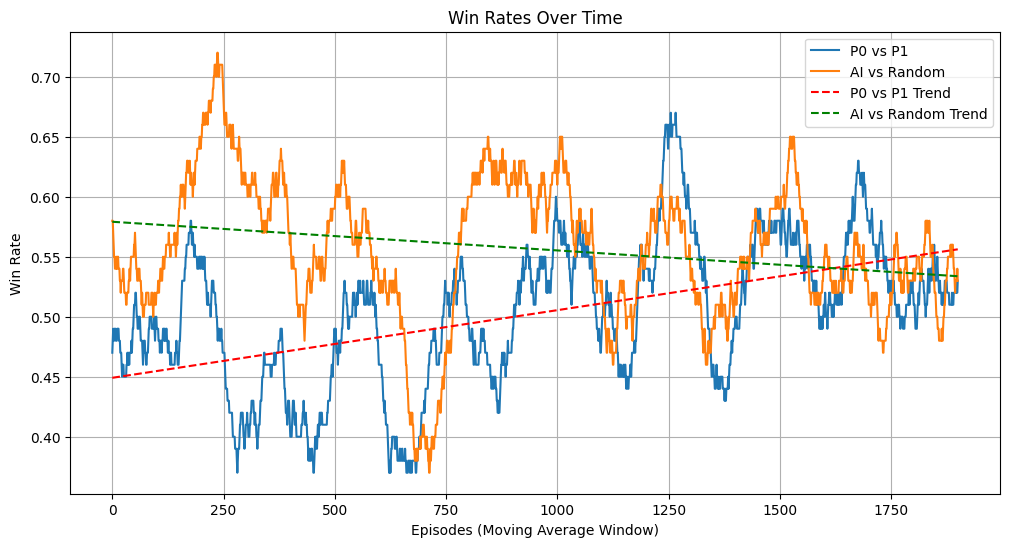

Recent win rate against random: 0.53
Episode 2400: Training in progress...


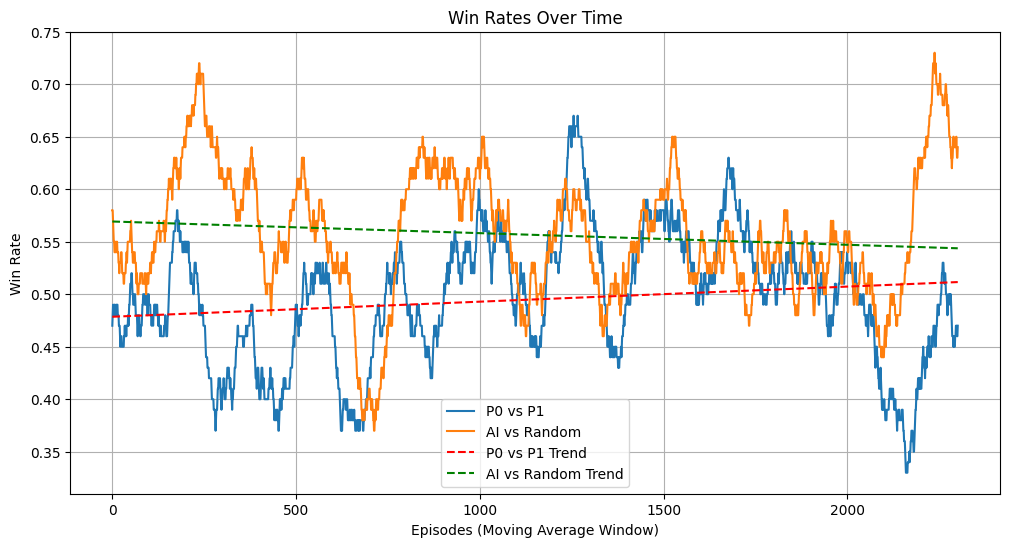

Recent win rate against random: 0.56
Episode 2800: Training in progress...


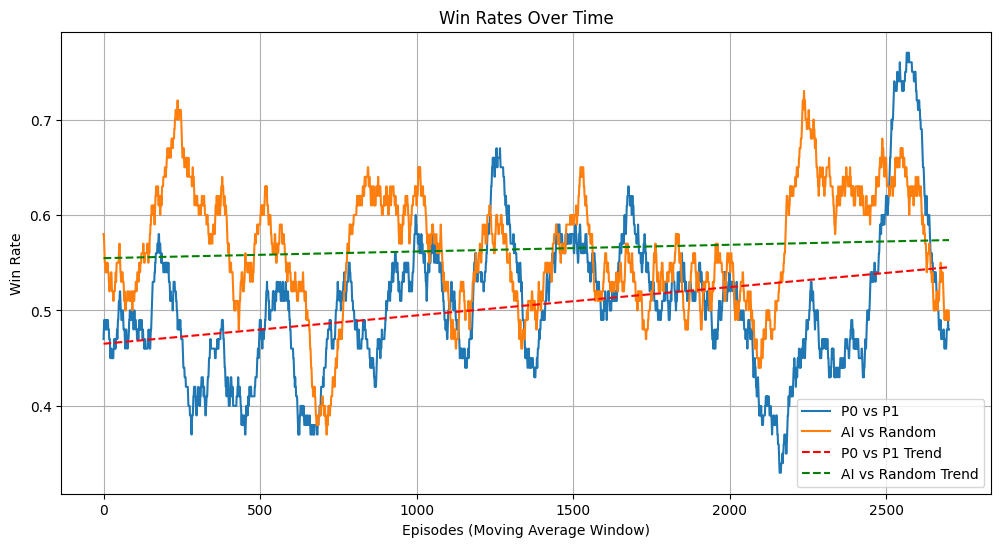

Recent win rate against random: 0.59
Episode 3200: Training in progress...


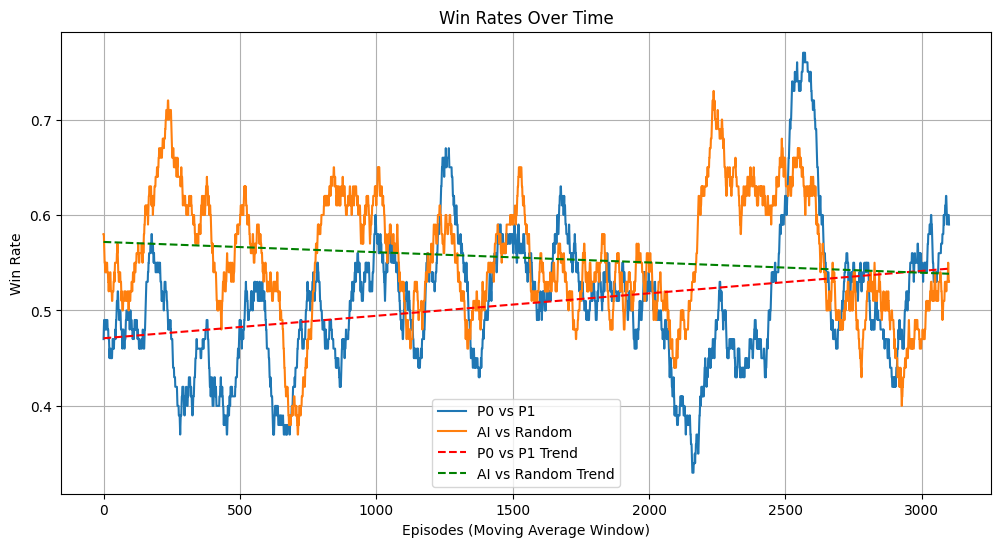

Recent win rate against random: 0.49
Episode 3600: Training in progress...


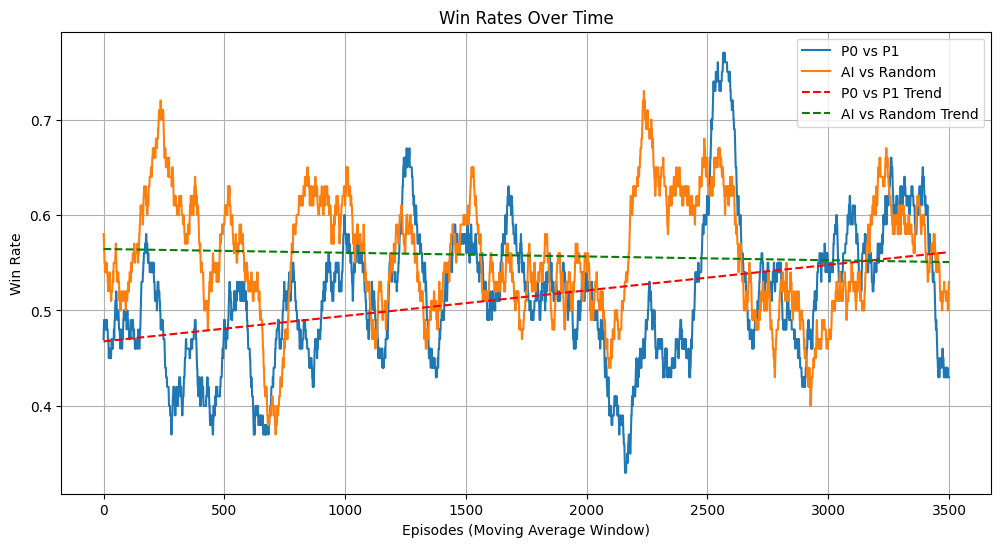

Recent win rate against random: 0.58
Episode 4000: Training in progress...


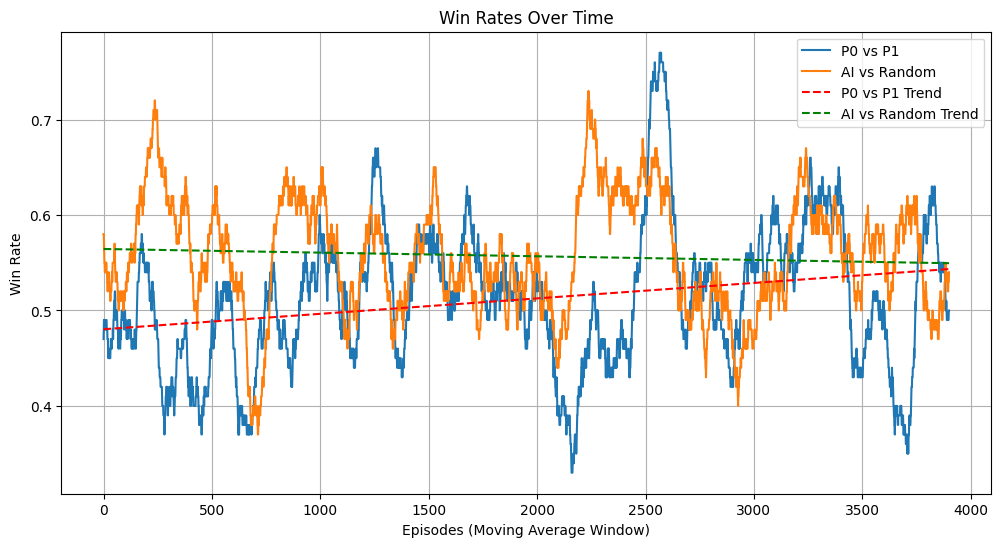

Recent win rate against random: 0.55
Episode 4400: Training in progress...


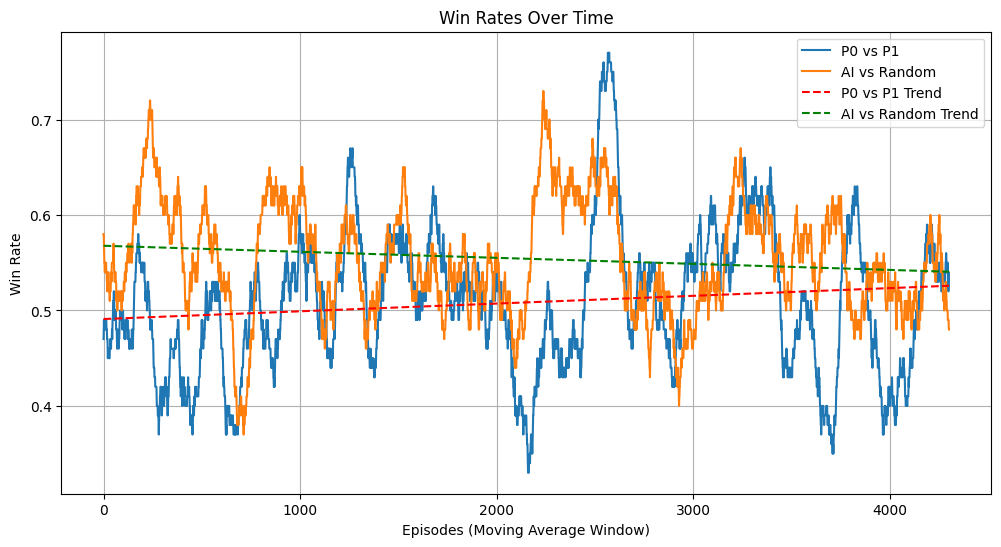

Recent win rate against random: 0.52
Episode 4800: Training in progress...


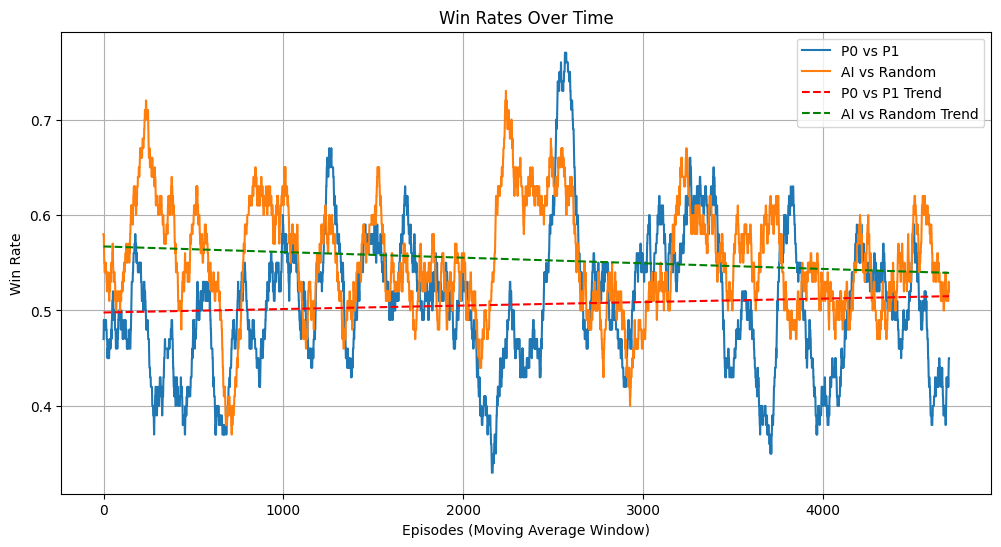

Recent win rate against random: 0.55
Episode 5200: Training in progress...


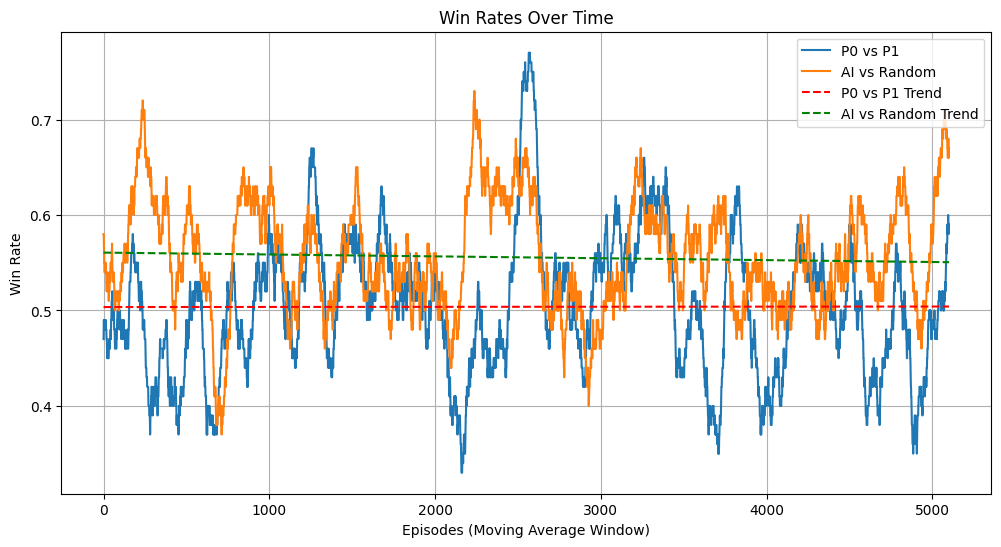

Recent win rate against random: 0.59
Episode 5600: Training in progress...


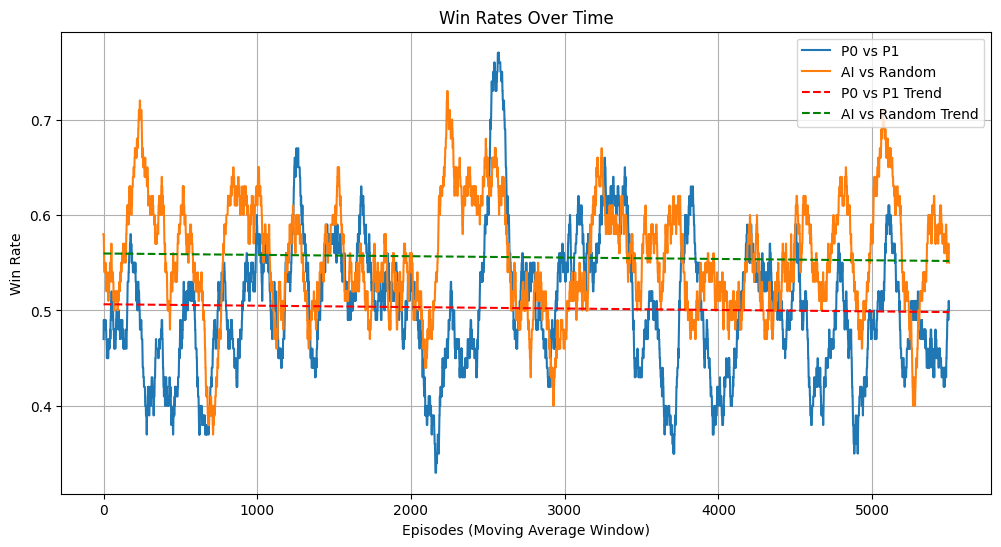

Recent win rate against random: 0.55
Episode 6000: Training in progress...


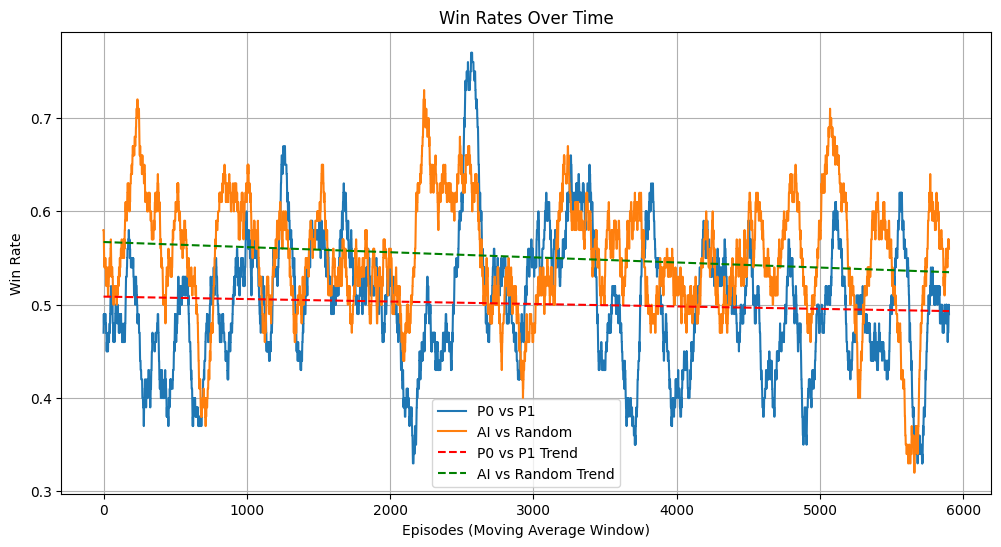

Recent win rate against random: 0.49
Episode 6400: Training in progress...


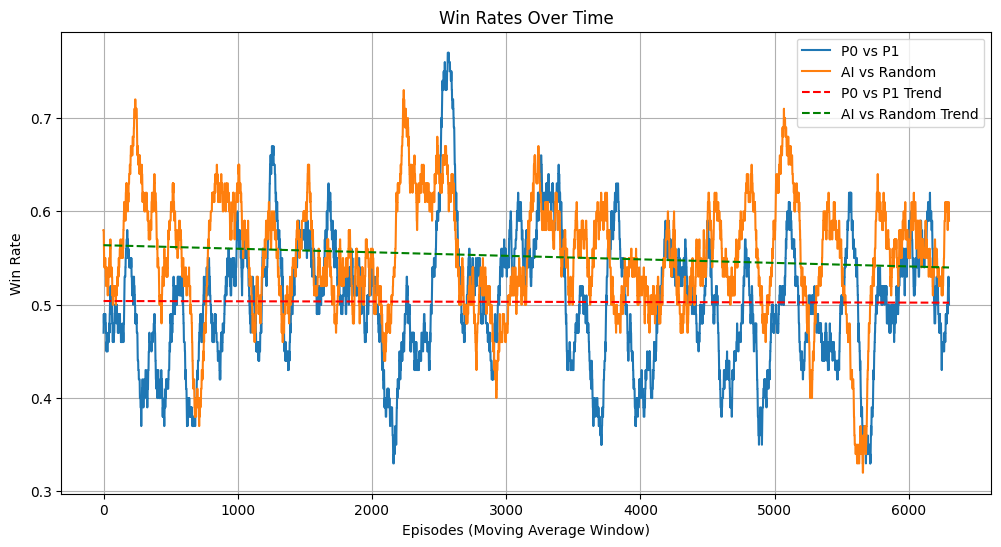

Recent win rate against random: 0.57
Episode 6800: Training in progress...


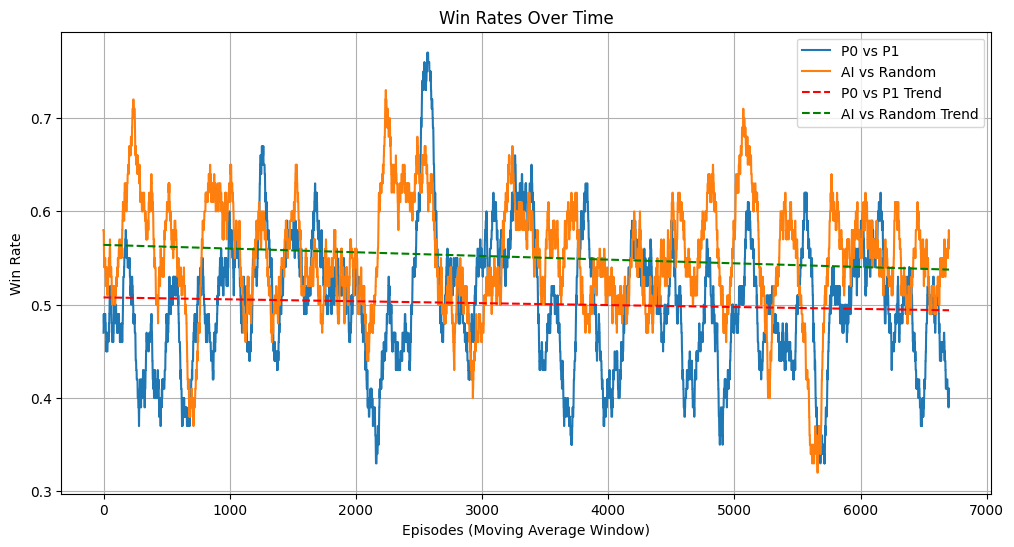

Recent win rate against random: 0.53
Episode 7200: Training in progress...


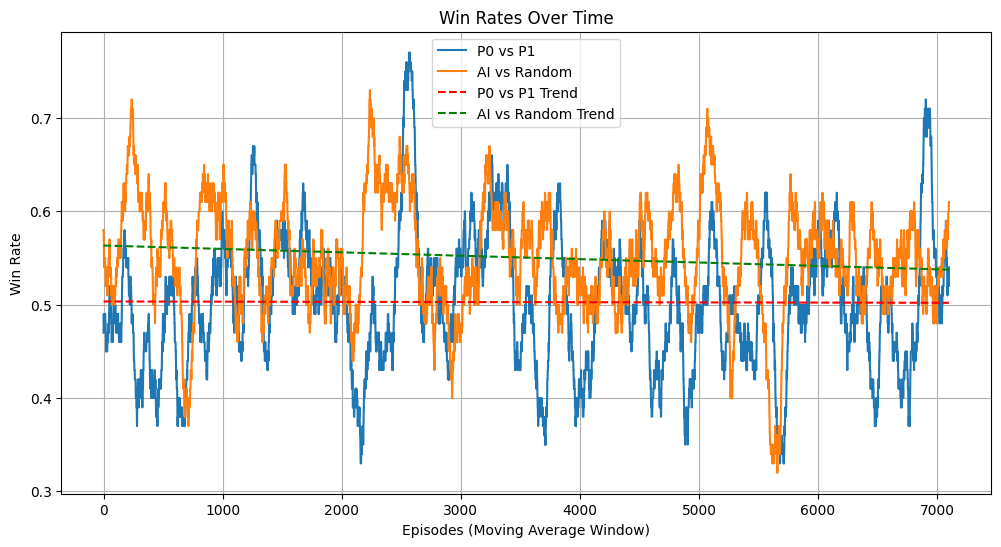

Recent win rate against random: 0.55
Episode 7600: Training in progress...


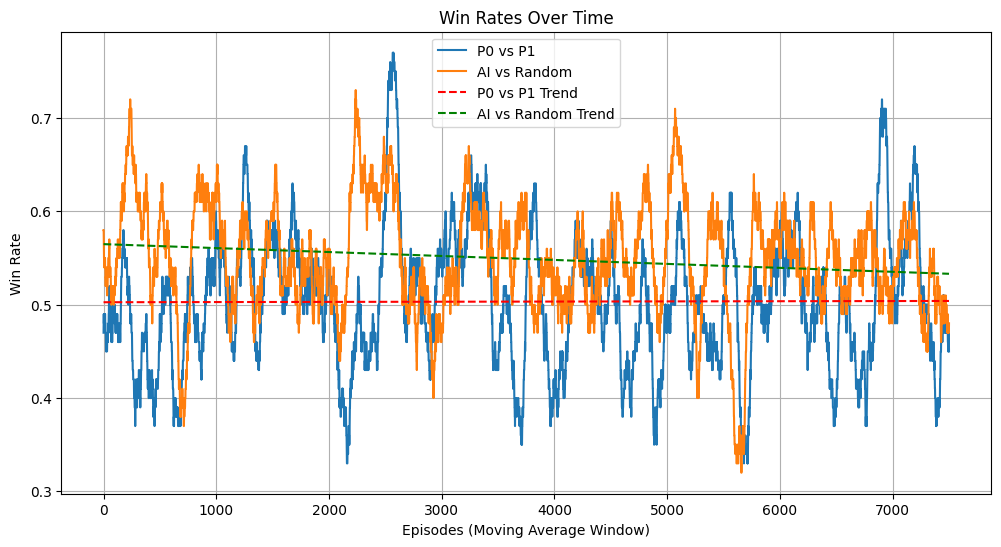

Recent win rate against random: 0.51
Episode 8000: Training in progress...


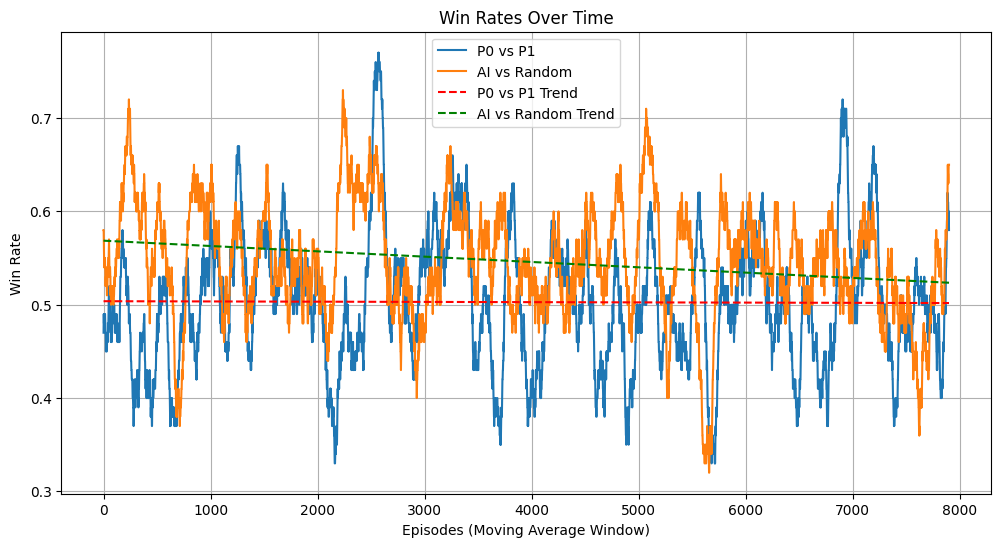

Recent win rate against random: 0.52
Episode 8400: Training in progress...


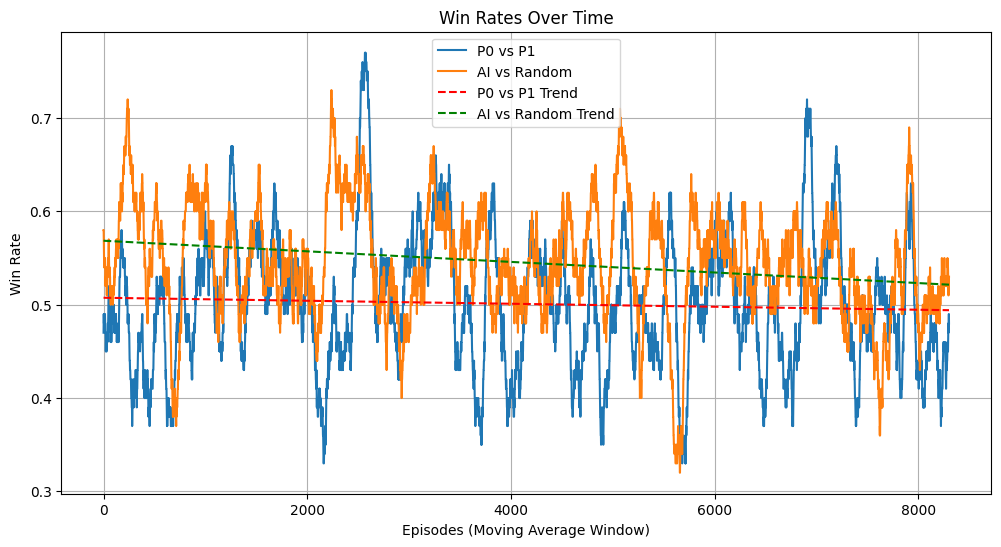

Recent win rate against random: 0.51
Episode 8800: Training in progress...


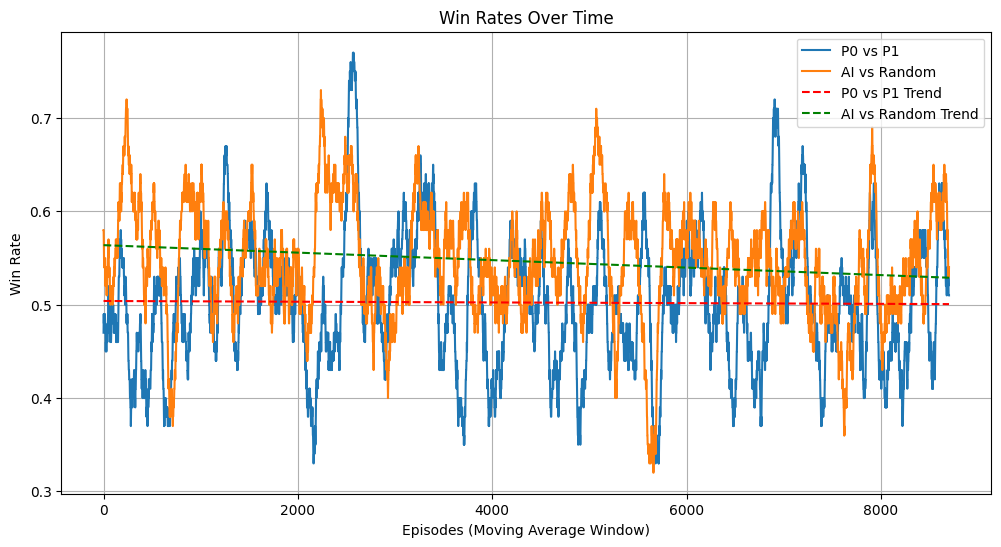

Recent win rate against random: 0.57
Episode 9200: Training in progress...


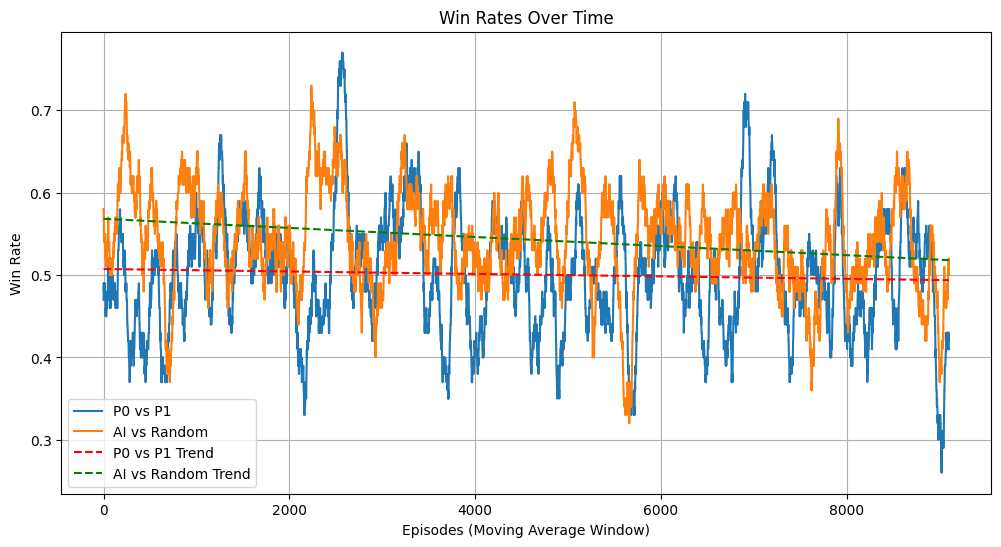

Recent win rate against random: 0.47
Episode 9600: Training in progress...


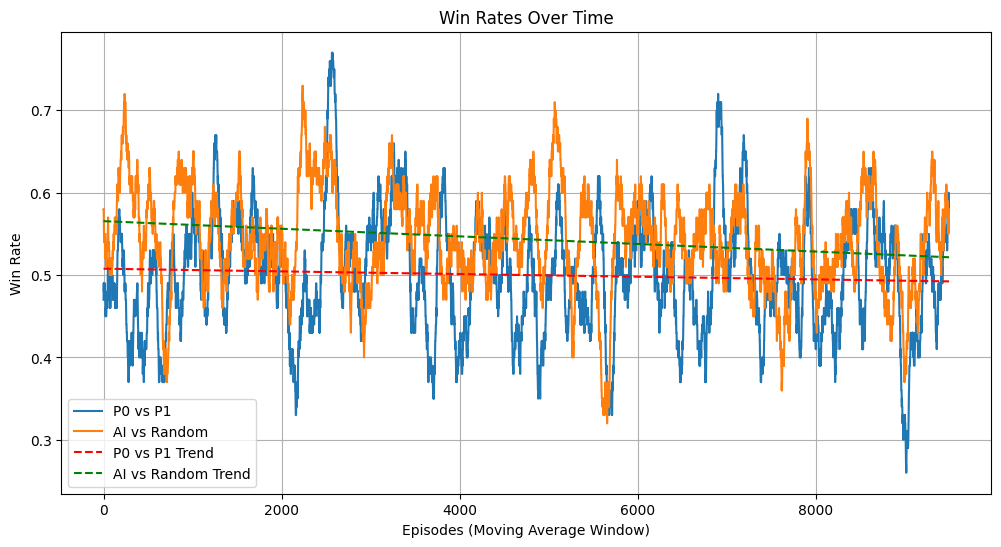

Recent win rate against random: 0.57
Episode 10000: Training in progress...


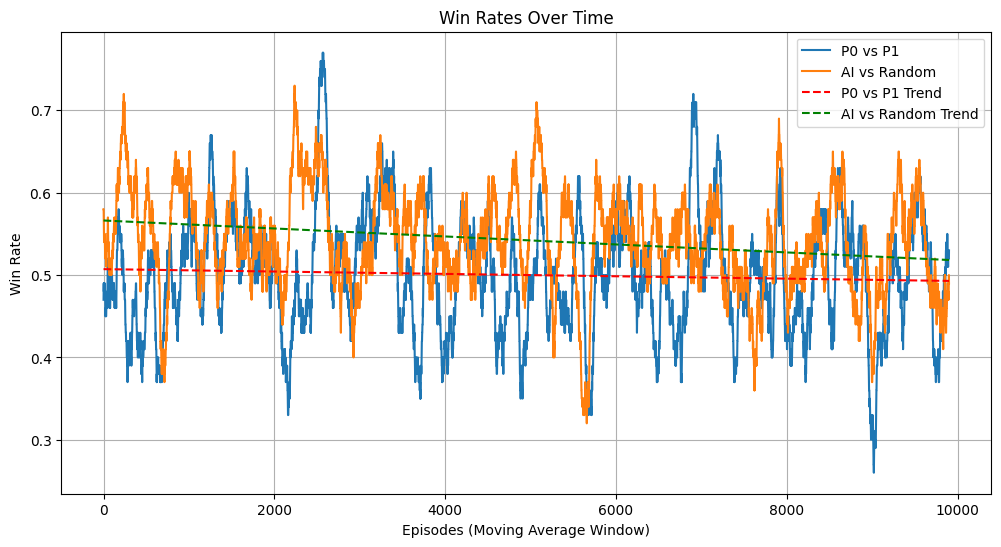

Recent win rate against random: 0.50
Total win rate against random: 0.5423
Training complete.
Training complete.
Initial alpha: 0.6000, Initial epsilon: 0.4000, Initial gamma: 0.8000
Final alpha: 0.6000, Final epsilon: 0.4000, Final gamma: 0.8000


In [20]:
class QLearningAgent:
    def __init__(self, env, alpha=0.6, gamma=0.8, epsilon=0.4):
        self.env = env
        #  env.size is the size of the board, 7 is the number of possible actions, 11 is the number of possible positions, 2 is the number of players
        self.q_table = [
            np.zeros((env.size, env.size, 7, 11, 2)),  # Player 0's Q-table 
            np.zeros((env.size, env.size, 7, 11, 2))   # Player 1's Q-table
        ]
        self.alpha = alpha # Learning rate, determines to what extent newly acquired information overrides old information
        self.gamma = gamma # Discount factor, determines the importance of future rewards
        self.epsilon = epsilon # Exploration rate, determines the probability of choosing a random action
        self.rewards = []
        self.p0_wins = []
        self.wins_against_random = []

    def save_model(self, filename):
        import pickle
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_model(self, filename):
        import pickle
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)

    def select_action(self, state, player):
        # Debug: Print the current state
        # print(f"\nCurrent state for player {player}:")
        # self.env.render()

        # Determine legal actions
        if np.random.rand() < self.epsilon:
            # Random exploration
            legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        else:
            # Exploitation
            legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
             
        # Debug: Print the legal actions available
        # print(f"Legal actions for player {player}: {legal_actions}")

        if not legal_actions:
            raise ValueError(f"No legal actions available for player {player} in state: {state}")

        # Check if we need to perform exploitation
        if np.random.rand() >= self.epsilon and legal_actions:
            action_q_values = []
            for a in legal_actions:
                action_index = a[0]
                if 0 <= action_index < self.q_table[player].shape[3]:
                    q_value = self.q_table[player][a[1], a[2], state[a[1], a[2]], action_index, player]
                    action_q_values.append(np.max(q_value))
                else:
                    action_q_values.append(float('-inf'))
            max_q_value_index = np.argmax(action_q_values)
            action = legal_actions[max_q_value_index]
        else:
            action = legal_actions[np.random.choice(len(legal_actions))]
        return action
        # Debug: Print the chosen action
        # action_name = ACTION_NAMES.get(action[0], "Unknown Action")
        # print(f"Chosen action for player {player}: {action_name} (Raw action: {action})")
        
        return action

    def update(self, state, action, reward, next_state, player):
        q_value = self.q_table[player][action[1], action[2], state[action[1], action[2]], action[0], player]
        max_next_q_value = np.max(self.q_table[player][action[1], action[2], :, :, player])
        self.q_table[player][action[1], action[2], state[action[1], action[2]], action[0], player] = q_value + self.alpha * (reward + self.gamma * max_next_q_value - q_value)


        # Debug: Print the Q-value update
        #  print(f"Updated Q-value for player {player}, state {state}, action {action}: {self.q_table[player][state[0], state[1], action[0], player]}")

    def plot_average_reward(self, window_size=100):
        if len(self.rewards) < window_size:
            print("Not enough data to plot average reward")
            return
        avg_rewards = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(avg_rewards)
        plt.title('Average Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.show()

    def plot_win_rate(self, window_size=100):
        if len(self.wins) < window_size:
            print("Not enough data to plot win rate")
            return
        win_rate = np.convolve(self.wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_q_value_heatmap(self, player, action):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.q_table[player][:, :, action, player], annot=True, cmap='YlGnBu')
        plt.title(f'Q-values for Player {player}, Action {action}')
        plt.xlabel('Y coordinate')
        plt.ylabel('X coordinate')
        plt.show()

    def plot_q_value_distribution(self):
        plt.figure(figsize=(10, 6))
        q_values = self.q_table[0].flatten()
        plt.hist(q_values, bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
        plt.title('Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.show()

    def plot_action_preference(self, player):
        preferred_actions = np.argmax(self.q_table[player], axis=2)
        plt.figure(figsize=(10, 8))
        sns.heatmap(preferred_actions[:, :, player], annot=True, cmap='YlGnBu')
        plt.title(f'Preferred Actions for Player {player}')
        plt.xlabel('Y coordinate')
        plt.ylabel('X coordinate')
        plt.show()

    def plot_random_agent_win_rate(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(10, len(self.random_agent_win_rates) * 10 + 1, 10), self.random_agent_win_rates)
        plt.title('Win Rate Against Random Agent')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.ylim(0, 1)
        plt.show()

    def plot_win_rates_with_trend(self):
        plt.figure(figsize=(12, 6))
        
        # AI vs AI win rate
        p0_win_rate = self.calculate_moving_average(self.p0_wins)
        plt.plot(p0_win_rate, label='P0 vs P1')
        
        # AI vs Random win rate
        ai_vs_random_win_rate = self.calculate_moving_average(self.wins_against_random)
        plt.plot(ai_vs_random_win_rate, label='AI vs Random')
        
        # Add trend lines
        x = np.arange(len(p0_win_rate))
        
        # AI vs AI trend line
        z_ai = np.polyfit(x, p0_win_rate, 1)
        p_ai = np.poly1d(z_ai)
        plt.plot(x, p_ai(x), "r--", label='P0 vs P1 Trend')
        
        # AI vs Random trend line
        z_random = np.polyfit(x, ai_vs_random_win_rate, 1)
        p_random = np.poly1d(z_random)
        plt.plot(x, p_random(x), "g--", label='AI vs Random Trend')
        
        plt.title('Win Rates Over Time')
        plt.xlabel('Episodes (Moving Average Window)')
        plt.ylabel('Win Rate')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def calculate_moving_average(self, data, window_size=100):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def evaluate_against_random(self, num_games):
        wins = 0
        for _ in range(num_games):
            state = self.env.reset(0)
            done = False
            player = 0
            while done > 1:
                if player == 0:
                    action = self.select_action(state, player)
                else:
                    action = self.random_agent(state, player)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                player = 1 - player
            if done == 0:
                wins += 1
        win_rate = wins / num_games
        print(f"Win rate against random agent: {win_rate:.2f}")
        return win_rate


    def plot_results(self):
        #self.plot_average_reward()
        #self.plot_average_reward()
        #self.plot_win_rate()
        self.plot_win_rates_with_trend()
        '''
        self.plot_q_value_heatmap(0, 0)
        self.plot_q_value_heatmap(0, 1)
        self.plot_q_value_heatmap(0, 2)
        self.plot_q_value_heatmap(0, 3)
        self.plot_q_value_heatmap(0, 4)
        self.plot_q_value_heatmap(0, 5)
        self.plot_q_value_distribution()
        self.plot_action_preference(0)'''

    def plot_ai_vs_ai_win_rate(self, window_size=100):
        if len(self.ai_vs_ai_wins) < window_size:
            print("Not enough data to plot AI vs AI win rate")
            return
        win_rate = np.convolve(self.ai_vs_ai_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs AI Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_ai_vs_random_win_rate(self, window_size=100):
        if len(self.ai_vs_random_wins) < window_size:
            print("Not enough data to plot AI vs Random win rate")
            return
        win_rate = np.convolve(self.ai_vs_random_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs Random Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()
        
    def train(self, episodes, eval_interval=500):
        initial_alpha = self.alpha
        initial_epsilon = self.epsilon
        initial_gamma = self.gamma
        
        for episode in range(episodes):
            # AI vs AI game
            state = self.env.reset(0)
            done = 2
            player = 0
            episode_reward = 0
            while done > 1:
                action = self.select_action(state, player)
                next_state, reward, done, _ = self.env.step(action)
                self.update(state, action, reward, next_state, player)
                state = next_state
                player = 1 - player
                episode_reward += reward
            self.rewards.append(episode_reward)
            self.p0_wins.append(1 if done == 0 else 0)

            # AI vs Random game
            ai_wins = self.play_against_random()
            self.wins_against_random.append(1 if ai_wins == 0 else 0)
            
            if (episode + 1) % eval_interval == 0:
                print(f"Episode {episode + 1}: Training in progress...")

                self.plot_results()
                
                # Calculate recent win rate against random
                recent_win_rate = sum(self.wins_against_random[-eval_interval:]) / eval_interval
                
                
                print(f"Recent win rate against random: {recent_win_rate:.2f}")

        print(f"Total win rate against random: {sum(self.wins_against_random)/episodes}")

        print("Training complete.")
        print("Training complete.")
        print(f"Initial alpha: {initial_alpha:.4f}, Initial epsilon: {initial_epsilon:.4f}, Initial gamma: {initial_gamma:.4f}")
        print(f"Final alpha: {self.alpha:.4f}, Final epsilon: {self.epsilon:.4f}, Final gamma: {self.gamma:.4f}")
        
        # Add this line to save the model after training
        self.save_model('trained_ghost_model.pkl')

    def plot_ai_vs_ai_win_rate(self, window_size=100):
        if len(self.ai_vs_ai_wins) < window_size:
            print("Not enough data to plot AI vs AI win rate")
            return
        win_rate = np.convolve(self.ai_vs_ai_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs AI Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def plot_ai_vs_random_win_rate(self, window_size=100):
        if len(self.ai_vs_random_wins) < window_size:
            print("Not enough data to plot AI vs Random win rate")
            return
        win_rate = np.convolve(self.ai_vs_random_wins, np.ones(window_size)/window_size, mode='valid')
        plt.figure(figsize=(10, 6))
        plt.plot(win_rate)
        plt.title('AI vs Random Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.show()

    def play(self):
        state = self.env.reset(0)
        done = False
        player = 0

        while not done:
            action = self.select_action(state, player)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            player = 1 - player

        print("Game over.")

    def random_agent(self, state, player):
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        return legal_actions[np.random.randint(len(legal_actions))]

    def get_human_action(self, state, player):
        self.env.render()
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        
        print("\nLegal actions:")
        for i, action in enumerate(legal_actions):
            action_name = ACTION_NAMES[action[0]]
            print(f"{i}: {action_name} at position ({action[1]}, {action[2]})")
        
        while True:
            try:
                choice = int(input("\nEnter the number of your chosen action: "))
                if 0 <= choice < len(legal_actions):
                    return legal_actions[choice]
                else:
                    print("Invalid choice. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    def play_against_human(self):
        state = self.env.reset()
        done = False
        player = 0  # 0 for human, 1 for AI

        while not done:
            if player == 0:
                action = self.get_human_action(state, player)
            else:
                action = self.select_action(state, player)
                print(f"\nAI chose action: {ACTION_NAMES[action[0]]} at position ({action[1]}, {action[2]})")

            next_state, reward, done, _ = self.env.step(action)
            print("reward ",reward)
            state = next_state
            player = 1 - player

        self.env.render()
        if reward > 0:
            print("You win!")
        elif reward < 0:
            print("AI wins!")
        else:
            print("It's a draw!")

    def play_against_random(self):
        state = self.env.reset(0)
        done = 2
        player = 0
        while done > 1:
            if player == 0:
                action = self.select_action(state, player)
            else:
                legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
                action = legal_actions[np.random.randint(len(legal_actions))]
            next_state, reward, done, _ = self.env.step(action)
            state = next_state
            player = 1 - player
        return done  

# Initialize the environment
env = GhostsEnv()


agent = QLearningAgent(env)
agent.train(episodes=10000, eval_interval=400)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os
import time

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.state_size = env.size * env.size * 7  # 7 possible values for each cell
        self.action_size = 11  # 11 possible actions
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = alpha
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    def _build_model(self):
        model = Sequential([
            Flatten(input_shape=(self.env.size, self.env.size, 7)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))       
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, player):
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        
        if not legal_actions:
            return None  # No legal actions available
        
        if np.random.rand() <= self.epsilon:
            return random.choice(legal_actions)
        
        state = self._preprocess_state(state)
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        state = tf.expand_dims(state, 0)  # Add batch dimension here
        act_values = self.model.predict(state, verbose=0)
        legal_act_values = [act_values[0][action[0]] for action in legal_actions]
        return legal_actions[np.argmax(legal_act_values)]

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        with tf.GradientTape() as tape:
            target = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            max_next_q_values = tf.reduce_max(next_q_values, axis=1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values
            masks = tf.one_hot(actions, self.action_size)
            q_values = tf.reduce_sum(target * masks, axis=1)
            loss = tf.keras.losses.MSE(target_q_values, q_values)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


    def _preprocess_state(self, state):
        encoded_state = np.zeros((self.env.size, self.env.size, 7))
        for i in range(self.env.size):
            for j in range(self.env.size):
                encoded_state[i, j, state[i, j]] = 1
        return encoded_state  # Remove the reshape here

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = np.array([self._preprocess_state(state) for state in states])
        next_states = np.array([self._preprocess_state(state) for state in next_states])
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor([action[0] for action in actions], dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        loss = self.train_step(states, actions, rewards, next_states, dones)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        #print(f"Replay completed. New epsilon: {self.epsilon:.4f}, Loss: {loss:.4f}")

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        if not name.endswith('.weights.h5'):
            name += '.weights.h5'
        self.model.save_weights(name)

    def evaluate_against_random(self, num_games=100):
        wins = 0
        draws = 0
        losses = 0
        for _ in range(num_games):
            state = self.env.reset()
            done = 2
            player = 0
            while done > 1:
                if player == 0:
                    action = self.act(state, player)
                else:
                    legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
                    action = random.choice(legal_actions) if legal_actions else None
                
                if action is None:
                    print(f"No legal actions for player {player}. Ending game.")
                    print("State:")
                    self.env.render()
                    done = 3  # Draw
                    break
                
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                player = 1 - player
                
                if done == 3:
                    print("Draw")
                    break
                
                
            if done == 0:  # Assuming 0 means player 0 (our agent) won
                wins += 1
            elif done == 1:
                losses += 1
            elif done == 3:
                draws += 1
        return wins / num_games, draws / num_games, losses / num_games

    def train(self, episodes, batch_size=128, eval_interval=500, eval_games=100):
        start_time = time.time()
        win_rates = []
        draw_rates = []
        loss_rates = []
        for episode in range(episodes):
            state = self.env.reset()
            done = 2
            player = 0
            total_reward = 0
            steps = 0
            while done > 1:
                action = self.act(state, player)
                if action is None:
                    print(f"No legal actions for player {player}. Ending game.")
                    print("State:")
                    self.env.render()
                    done = 3  # Draw
                    break
                
                next_state, reward, done, _ = self.env.step(action)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                player = 1 - player
                total_reward += reward
                steps += 1

                if done == 3:
                    print("Draw")
                    break
                

                if len(self.memory) > batch_size:
                    self.replay(batch_size)

            elapsed_time = time.time() - start_time
            print(f"Episode: {episode}, Steps: {steps}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}, Elapsed Time: {elapsed_time:.2f}s")

            if (episode + 1) % eval_interval == 0:
                win_rate, draws_rate, losses_rate = self.evaluate_against_random(eval_games)
                win_rates.append(win_rate)
                draw_rates.append(draws_rate)
                loss_rates.append(losses_rate)
                print(f"Episode {episode + 1}:\n Win rate against random agent: {win_rate:.2f}", f"\nDraw rate against random agent: {draws_rate:.2f}", f"\nLoss rate against random agent: {losses_rate:.2f}")
                self.update_target_model()

        self.save("dqn_ghost_model.h5")
        print("Training completed.")
        return win_rates, draw_rates, loss_rates

    def plot_win_rates(self, win_rates, eval_interval):
        plt.figure(figsize=(10, 6))
        plt.plot(range(eval_interval, len(win_rates) * eval_interval + 1, eval_interval), win_rates)
        plt.title('Win Rate Against Random Agent Over Time')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.ylim(0, 1)
        plt.show()
        
    def plot_rates(self, win_rates, draw_rates, loss_rates, eval_interval):
        plt.figure(figsize=(10, 6))
        plt.plot(range(eval_interval, len(win_rates) * eval_interval + 1, eval_interval), win_rates, label='Win Rate')
        plt.plot(range(eval_interval, len(draw_rates) * eval_interval + 1, eval_interval), draw_rates, label='Draw Rate')
        plt.plot(range(eval_interval, len(loss_rates) * eval_interval + 1, eval_interval), loss_rates, label='Loss Rate')
        plt.title('Evaluation Rates Over Time')
        plt.xlabel('Episode')
        plt.ylabel('Rate')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

# Usage
env = GhostsEnv()
agent = DQNAgent(env)
win_rates, draws_rates, losses_rates = agent.train(episodes=100, eval_interval=20, eval_games=25)


c:\Users\lucac\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Draw
Episode: 0, Steps: 116, Total Reward: -270, Epsilon: 1.00, Elapsed Time: 0.00s
Draw
Episode: 1, Steps: 116, Total Reward: -270, Epsilon: 0.60, Elapsed Time: 1.75s
Draw
Episode: 2, Steps: 116, Total Reward: -250, Epsilon: 0.34, Elapsed Time: 4.14s
Player Blue count is 0
Episode: 3, Steps: 108, Total Reward: 374, Epsilon: 0.20, Elapsed Time: 7.88s
Opponent Blue count is 0
Episode: 4, Steps: 105, Total Reward: 380, Epsilon: 0.12, Elapsed Time: 12.01s
Draw
Episode: 5, Steps: 116, Total Reward: -330, Epsilon: 0.06, Elapsed Time: 17.28s
Opponent Red count is 0
Episode: 6, Steps: 99, Total Reward: -668, Epsilon: 0.04, Elapsed Time: 21.81s
Opponent Red count is 0
Episode: 7, Steps: 67, Total Reward: -624, Epsilon: 0.03, Elapsed Time: 24.45s
Player Blue count is 0
Episode: 8, Steps: 96, Total Reward: 358, Epsilon: 0.02, Elapsed Time: 28.37s
Opponent Blue count is 0
Episode: 9, Steps: 75, Total Reward: 480, Epsilon: 0.01, Elapsed Time: 31.51s
Episode: 10, Steps: 68, Total Reward: 434, Epsil

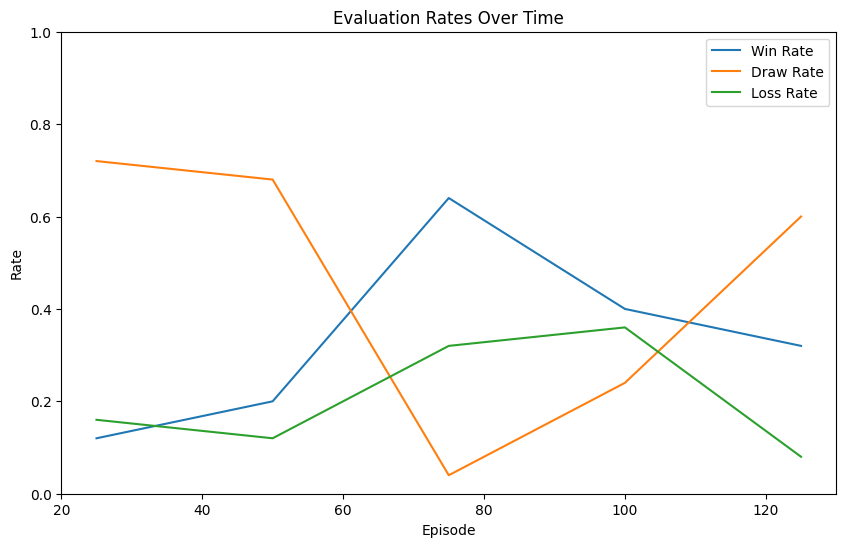

Win rates:  [0.12, 0.2, 0.64, 0.4, 0.32]
Draw rates:  [0.72, 0.68, 0.04, 0.24, 0.6]
Loss rates:  [0.16, 0.12, 0.32, 0.36, 0.08]


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

agent.plot_rates(win_rates, draws_rates, losses_rates, 25)
print("Win rates: ", win_rates)
print("Draw rates: ", draws_rates)
print("Loss rates: ", losses_rates)

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.state_size = env.size * env.size * 7
        self.action_size = 11
        self.memory = deque(maxlen=2000)
        self.gamma = gamma # Discount rate
        self.epsilon = epsilon # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = alpha
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.opponent_model = None  # Add this line
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    def _build_model(self):
        model = Sequential([
            Flatten(input_shape=(self.env.size, self.env.size, 7)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))       
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, player, use_epsilon=True):
        if player == 1:
            # Opponent's turn
            # [Existing code for opponent's action]
            pass  # You can keep the existing code here

        # Player's turn
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        if not legal_actions:
            return None  # No legal actions available

        if use_epsilon and np.random.rand() <= self.epsilon:
            return random.choice(legal_actions)

        state_input = self._preprocess_state(state)
        state_input = tf.convert_to_tensor(state_input, dtype=tf.float32)
        state_input = tf.expand_dims(state_input, 0)
        act_values = self.model.predict(state_input, verbose=0)
        legal_act_values = [act_values[0][action[0]] for action in legal_actions]
        return legal_actions[np.argmax(legal_act_values)]


    
    def opponent_act(self, state, player):
        flipped_state = self.flip_state(state)
        # Generate legal actions for player 0 on the flipped state
        if self.env.phase == 0:
            legal_actions = self.env.legal_placement_actions(0, flipped_state, flipped=True)
        else:
            legal_actions = self.env.legal_movement_actions(0, flipped_state)
        if not legal_actions:
            return None
        state_input = self._preprocess_state(flipped_state)
        state_input = tf.convert_to_tensor(state_input, dtype=tf.float32)
        state_input = tf.expand_dims(state_input, 0)
        act_values = self.opponent_model.predict(state_input, verbose=0)
        legal_act_values = [act_values[0][action[0]] for action in legal_actions]
        best_action = legal_actions[np.argmax(legal_act_values)]
        action = self.flip_action(best_action)
        return action


    def flip_state(self, state):
        flipped_state = np.flipud(np.fliplr(state))
        remapped_state = np.copy(flipped_state)
        
        # Map from original IDs to remapped IDs
        id_mapping = {
            PLAYER_BLUE: OPPONENT_BLUE,
            PLAYER_RED: OPPONENT_RED,
            OPPONENT_BLUE: PLAYER_BLUE,
            OPPONENT_RED: PLAYER_RED,
            PLAYER_MASKED: OPPONENT_MASKED,
            OPPONENT_MASKED: PLAYER_MASKED,
            EMPTY: EMPTY
        }
        
        for original_id, remapped_id in id_mapping.items():
            remapped_state[flipped_state == original_id] = remapped_id

        return remapped_state



    def flip_action(self, action):
        action_type, x, y, player = action
        flipped_action_type = self.flip_action_type(action_type)
        flipped_x = self.env.size - 1 - x
        flipped_y = self.env.size - 1 - y
        return (flipped_action_type, flipped_x, flipped_y, player)

    def flip_action_type(self, action_type):
        flip_mapping = {
            # Movement actions
            0: 2,  # UP becomes DOWN
            1: 3,  # RIGHT becomes LEFT
            2: 0,  # DOWN becomes UP
            3: 1,  # LEFT becomes RIGHT
            # Placement actions remain the same
            4: 4,  # PLACE BLUE
            5: 5,  # PLACE RED
            # Capture actions
            6: 8,  # CAPTURE UP becomes CAPTURE DOWN
            7: 9,  # CAPTURE RIGHT becomes CAPTURE LEFT
            8: 6,  # CAPTURE DOWN becomes CAPTURE UP
            9: 7,  # CAPTURE LEFT becomes CAPTURE RIGHT
            10: 10  # If there's an action 10, adjust accordingly
        }
        return flip_mapping.get(action_type, action_type)


    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        with tf.GradientTape() as tape:
            target = self.model(states, training=True)
            next_q_values = self.target_model(next_states, training=False)
            max_next_q_values = tf.reduce_max(next_q_values, axis=1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values
            masks = tf.one_hot(actions, self.action_size)
            q_values = tf.reduce_sum(target * masks, axis=1)
            loss = tf.keras.losses.MSE(target_q_values, q_values)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


    def _preprocess_state(self, state):
        encoded_state = np.zeros((self.env.size, self.env.size, 7))
        for i in range(self.env.size):
            for j in range(self.env.size):
                piece_id = int(state[i, j])
                encoded_state[i, j, piece_id] = 1
        return encoded_state


    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = np.array([self._preprocess_state(state) for state in states])
        next_states = np.array([self._preprocess_state(state) for state in next_states])
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor([action[0] for action in actions], dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        loss = self.train_step(states, actions, rewards, next_states, dones)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        #print(f"Replay completed. New epsilon: {self.epsilon:.4f}, Loss: {loss:.4f}")

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        if not name.endswith('.weights.h5'):
            name += '.weights.h5'
        self.model.save_weights(name)



    def train(self, n_segments, k_games_per_segment, batch_size=16):
        start_time = time.time()
        win_rates = []
        draw_rates = []
        loss_rates = []
        total_wins = 0
        total_draws = 0
        total_losses = 0
        outcomes = []
        for segment in range(n_segments):
            if segment == 0:
                self.opponent_model = None  # Use random opponent initially
            else:
                # Clone the agent's model to be the opponent
                self.opponent_model = self.clone_model()
                self.epsilon = 0.85
            for game in range(k_games_per_segment):
                state = self.env.reset()
                done = 2
                player = 0
                total_reward = 0
                steps = 0
                print_game = (game == 0)  # Print the first game of each segment
                while True:
                    if player == 0:
                        action = self.act(state, player)
                    else:
                        if self.opponent_model is None:
                            # Random opponent
                            legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
                            action = random.choice(legal_actions) if legal_actions else None
                        else:
                            action = self.opponent_act(state, player)
                    if action is None:
                        print(f"No legal actions for player {player}. Ending game.")
                        if print_game:
                            print("Final State:")
                            self.env.render()
                        # Get the actual game status
                        done = self.env._is_done(player)
                        # If the game isn't over, the player with no moves loses
                        if done > 1:
                            done = 1 if player == 0 else 0
                        break

                    next_state, reward, done, _ = self.env.step(action)

                    if print_game:
                        print(f"Player {player} took action {action}")
                        self.env.render()

                    if player == 0:
                        self.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward
                    steps += 1

                    if done <= 1 or done == 3:
                        break

                    player = 1 - player

                    if len(self.memory) > batch_size and player == 0:
                        self.replay(batch_size)
                elapsed_time = time.time() - start_time
                print(f"Segment: {segment + 1}, Game: {game + 1}, Steps: {steps}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.2f}, Elapsed Time: {elapsed_time:.2f}s")

                # Record the outcome
                if done == 0:  # Agent wins
                    total_wins += 1
                    outcomes.append(1)
                    print("Agent wins!")
                elif done == 1:  # Agent loses
                    total_losses += 1
                    outcomes.append(0)
                    print("Agent loses.")
                elif done == 3:  # Draw
                    total_draws += 1
                    outcomes.append(0.5)
                    print("Game ended in a draw.")
                else:
                    outcomes.append(0)
                    print("Unexpected game outcome.")

                # Calculate cumulative rates
                total_games_played = len(outcomes)
                win_rate = total_wins / total_games_played
                draw_rate = total_draws / total_games_played
                loss_rate = total_losses / total_games_played
                win_rates.append(win_rate)
                draw_rates.append(draw_rate)
                loss_rates.append(loss_rate)

            self.update_target_model()
        self.save("dqn_ghost_model.h5")
        print("Training completed.")
        return win_rates, draw_rates, loss_rates



    
    def clone_model(self):
        cloned_model = self._build_model()
        cloned_model.set_weights(self.model.get_weights())
        return cloned_model



    def plot_win_rates(self, win_rates, eval_interval):
        plt.figure(figsize=(10, 6))
        plt.plot(range(eval_interval, len(win_rates) * eval_interval + 1, eval_interval), win_rates)
        plt.title('Win Rate Against Random Agent Over Time')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.ylim(0, 1)
        plt.show()

    def moving_average(self, data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def plot_rates(self, win_rates, draw_rates, loss_rates, window_size=10):
        episodes = list(range(1, len(win_rates) + 1))
        win_rates_smooth = self.moving_average(win_rates, window_size)
        draw_rates_smooth = self.moving_average(draw_rates, window_size)
        loss_rates_smooth = self.moving_average(loss_rates, window_size)
        episodes_smooth = episodes[window_size - 1:]

        plt.figure(figsize=(10, 6))
        plt.plot(episodes_smooth, win_rates_smooth, label='Win Rate')
        plt.plot(episodes_smooth, draw_rates_smooth, label='Draw Rate')
        plt.plot(episodes_smooth, loss_rates_smooth, label='Loss Rate')
        plt.title('Smoothed Win/Draw/Loss Rates Over Episodes')
        plt.xlabel('Game Number')
        plt.ylabel('Rate')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

    def evaluate_against_random(self, num_games):
        outcomes = []
        for game in range(num_games):
            state = self.env.reset()
            done = 2
            player = 0
            while True:
                if player == 0:
                    # Agent's turn
                    action = self.act(state, player, use_epsilon=False)
                else:
                    # Random opponent
                    legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
                    action = random.choice(legal_actions) if legal_actions else None
                if action is None:
                    print(f"No legal actions for player {player}. Ending game.")
                    # Get the actual game status
                    done = self.env._is_done(player)
                    # If the game isn't over, the player with no moves loses
                    if done > 1:
                        done = 1 if player == 0 else 0
                    break

                next_state, reward, done, _ = self.env.step(action)
                state = next_state

                if done <= 1 or done == 3:
                    break

                player = 1 - player

            # Record the outcome
            if done == 0:  # Agent wins
                outcomes.append(1)
                print(f"Game {game + 1}: Agent wins!")
            elif done == 1:  # Agent loses
                outcomes.append(0)
                print(f"Game {game + 1}: Agent loses.")
            elif done == 3:  # Draw
                outcomes.append(0.5)
                print(f"Game {game + 1}: Game ended in a draw.")
            else:
                outcomes.append(0)
                print(f"Game {game + 1}: Unexpected game outcome.")

        
    def get_human_action(self, state, player):
        self.env.render()
        legal_actions = self.env.legal_placement_actions(player) if self.env.phase == 0 else self.env.legal_movement_actions(player)
        
        print("\nLegal actions:")
        for i, action in enumerate(legal_actions):
            action_name = ACTION_NAMES[action[0]]
            print(f"{i}: {action_name} at position ({action[1]}, {action[2]})")
        
        while True:
            try:
                choice = int(input("\nEnter the number of your chosen action: "))
                if 0 <= choice < len(legal_actions):
                    return legal_actions[choice]
                else:
                    print("Invalid choice. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    def play_against_human(self):
        state = self.env.reset()
        done = False
        player = 0  # 0 for human, 1 for AI

        while True:
            if player == 0:
                # Agent's turn                
                action = self.get_human_action(state, player)
            else:
                action = self.act(state, player, use_epsilon=False)
            if action is None:
                print(f"No legal actions for player {player}. Ending game.")
                # Get the actual game status
                done = self.env._is_done(player)
                # If the game isn't over, the player with no moves loses
                if done > 1:
                    done = 1 if player == 0 else 0
                break

            next_state, reward, done, _ = self.env.step(action)
            state = next_state

            if done <= 1 or done == 3:
                break

            player = 1 - player




Player 0 took action (4, 4, 4, 0)

 0 1 2 3 4 5
0 . . . . . .
1 . . . . . .
2 . . . . . .
3 . . . . . .
4 . . . . B .
5 . . . . . .

Player 1 took action (4, 1, 3, 1)

 0 1 2 3 4 5
0 . . . . . .
1 . . . b . .
2 . . . . . .
3 . . . . . .
4 . . . . B .
5 . . . . . .

Player 0 took action (4, 4, 1, 0)

 0 1 2 3 4 5
0 . . . . . .
1 . . . b . .
2 . . . . . .
3 . . . . . .
4 . B . . B .
5 . . . . . .

Player 1 took action (4, 1, 2, 1)

 0 1 2 3 4 5
0 . . . . . .
1 . . b b . .
2 . . . . . .
3 . . . . . .
4 . B . . B .
5 . . . . . .

Player 0 took action (5, 5, 2, 0)

 0 1 2 3 4 5
0 . . . . . .
1 . . b b . .
2 . . . . . .
3 . . . . . .
4 . B . . B .
5 . . R . . .

Player 1 took action (4, 0, 1, 1)

 0 1 2 3 4 5
0 . b . . . .
1 . . b b . .
2 . . . . . .
3 . . . . . .
4 . B . . B .
5 . . R . . .

Player 0 took action (4, 4, 3, 0)

 0 1 2 3 4 5
0 . b . . . .
1 . . b b . .
2 . . . . . .
3 . . . . . .
4 . B . B B .
5 . . R . . .

Player 1 took action (5, 1, 4, 1)

 0 1 2 3 4 5
0 . b . . . .
1 . . b

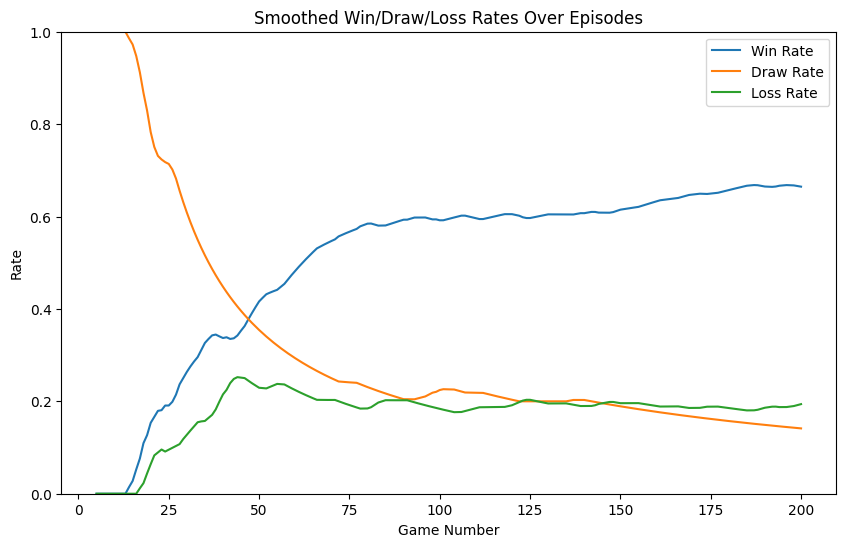

In [28]:
# Usage
# Usage
env = GhostsEnv()
agent = DQNAgent(env)
win_rates, draws_rates, losses_rates = agent.train(n_segments=10, k_games_per_segment=20)
agent.plot_rates(win_rates, draws_rates, losses_rates, window_size=5)

In [39]:
def plot_evaluation_rates(win_rates, draw_rates, loss_rates):
    episodes = list(range(1, len(win_rates) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, win_rates, label='Win Rate')
    plt.plot(episodes, draw_rates, label='Draw Rate')
    plt.plot(episodes, loss_rates, label='Loss Rate')
    plt.title('Evaluation: Win/Draw/Loss Rates Against Random Opponent')
    plt.xlabel('Game Number')
    plt.ylabel('Rate')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    
# Evaluate the agent
k = 150  # Number of evaluation games
eval_win_rates, eval_draw_rates, eval_loss_rates = agent.evaluate_against_random(num_games=k)
plot_evaluation_rates(eval_win_rates, eval_draw_rates, eval_loss_rates)
print(f"Win rate: {eval_win_rates[-1]:.2f}, Draw rate: {eval_draw_rates[-1]:.2f}, Loss rate: {eval_loss_rates[-1]:.2f}")


Game 1: Game ended in a draw.
Game 2: Game ended in a draw.
Player Blue at 0, 0
Game 3: Agent wins!
Player Red count is 0
Game 4: Agent wins!
Player Blue at 0, 0
Game 5: Agent wins!
Player Blue at 0, 0
Game 6: Agent wins!
Player Blue at 0, 0
Game 7: Agent wins!
Opponent Red count is 0
Game 8: Agent loses.
Opponent Red count is 0
Game 9: Agent loses.
Player Blue at 0, 0
Game 10: Agent wins!
Opponent Blue count is 0
Game 11: Agent wins!
Player Blue at 0, 0
Game 12: Agent wins!
Game 13: Game ended in a draw.
Opponent Red count is 0
Game 14: Agent loses.
Player Blue at 0, 0
Game 15: Agent wins!
Opponent Blue count is 0
Game 16: Agent wins!
Player Blue count is 0
Game 17: Agent loses.
Player Blue at 0, 0
Game 18: Agent wins!
Game 19: Agent loses.
Player Blue at 0, 0
Game 20: Agent wins!
Player Blue at 0, 0
Game 21: Agent wins!
Player Blue at 0, 0
Game 22: Agent wins!
Player Blue at 0, 0
Game 23: Agent wins!
Player Blue at 0, 0
Game 24: Agent wins!
Player Blue at 0, 0
Game 25: Agent wins!
Pl

KeyboardInterrupt: 

In [7]:

# Play against the trained AI
while True:
    play_again = input("Do you want to play against the AI? (yes/no): ").lower()
    if play_again != 'yes':
        break
    agent.play_against_human()

print("Thanks for playing!")


Thanks for playing!


In [48]:
# Load the trained model
env = GhostsEnv()
agent = DQNAgent(env)
agent.load("dqn_ghost_model.h5.weights.h5")

# Play against the trained AI
while True:
    play_again = input("Do you want to play against the AI? (yes/no): ").lower()
    if play_again != 'yes':
        break
    agent.play_against_human()


 0 1 2 3 4 5
0 . . . . . .
1 . . . . . .
2 . . . . . .
3 . . . . . .
4 . . . . . .
5 . . . . . .


Legal actions:
0: Place Blue Piece at position (4, 1)
1: Place Blue Piece at position (4, 2)
2: Place Blue Piece at position (4, 3)
3: Place Blue Piece at position (4, 4)
4: Place Blue Piece at position (5, 1)
5: Place Blue Piece at position (5, 2)
6: Place Blue Piece at position (5, 3)
7: Place Blue Piece at position (5, 4)
8: Place Red Piece at position (4, 1)
9: Place Red Piece at position (4, 2)
10: Place Red Piece at position (4, 3)
11: Place Red Piece at position (4, 4)
12: Place Red Piece at position (5, 1)
13: Place Red Piece at position (5, 2)
14: Place Red Piece at position (5, 3)
15: Place Red Piece at position (5, 4)

 0 1 2 3 4 5
0 . M . . . .
1 . . . . . .
2 . . . . . .
3 . . . . . .
4 . B . . . .
5 . . . . . .


Legal actions:
0: Place Blue Piece at position (4, 2)
1: Place Blue Piece at position (4, 3)
2: Place Blue Piece at position (4, 4)
3: Place Blue Piece at position

KeyboardInterrupt: Interrupted by user